<a href="https://colab.research.google.com/github/k4404c/tensorflow_workbook/blob/main/tensorflow5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Intro to NLP in tensorflow

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e225d771-010b-69a7-c117-e25a329873b7)


In [3]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir



--2024-05-19 21:26:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-19 21:26:30 (65.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
#Going to be using kaggles intro to NLP dataset

# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-05-19 21:26:41--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.207, 172.217.214.207, 172.253.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2024-05-19 21:26:42 (86.4 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [7]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [8]:
#shuffle df
train_df_shuffled = train_df.sample(frac = 1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
#how many examples of each class
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [11]:
#number total samples
len(train_df), len(test_df)

(7613, 3263)

In [12]:
import random
rand_idx = random.randint(0,len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][rand_idx:rand_idx+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target> 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0 (not real disaster)
Text:
'If you are going to achieve excellence in big things you develop the habit in little matters....' dont know the author

----

Target: 0 (not real disaster)
Text:
Has #IdentityTheft Derailed Your #TaxReturn? 
8 Steps for Cleaning Up an  #IdentityTheft Train Wreck. #CRI
http://t.co/gxQWD1qZBd

----

Target: 0 (not real disaster)
Text:
@realhotcullen I agree but I knew we'd be going to the deep roads again because they found Blight in red lyrium. It ain't over yet &gt;_&gt;

----

Target: 1 (real disaster)
Text:
in BOTH 'peacetime and times of national emergency.'

----

Target: 0 (not real disaster)
Text:
Aftershock ã¢ (2010) Fullã¢ Streaming - YouTube http://t.co/vVE3UsesGf

----



In [13]:
#split data into training and validation
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [14]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)


(6851, 6851, 762, 762)

In [15]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [16]:
#converting text data to numbers using tokenisation and embeddings
#when dealing with a text problem, we need to convert text to numbers^

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

#use default paramaters
text_vectorizer = TextVectorization(max_tokens= None, #how many words in vocabulary
                                    standardize = "lower_and_strip_punctuation",
                                    split= "whitespace",
                                    ngrams= None, #how large we group words
                                    output_mode = "int", #how to map tokens to numbers
                                    output_sequence_length = None, #how long do we want out sequences to be
                                    pad_to_max_tokens = None
                                    )

In [17]:
len(train_sentences[0].split())

7

In [18]:
#find avg number of tokens (words) in training tweets
round(sum([len(i.split()) for i in train_sentences])/ len(train_sentences))

15

In [19]:
#setup text vectorization variables
max_vocab_length = 10000 #max num words to have in vocab
max_length = 15 #max length our sequence will be

In [20]:
text_vectorizer = TextVectorization(max_tokens= max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length
                                    )

In [21]:
#map text vectorizor to training data
text_vectorizer.adapt(train_sentences)

In [22]:
#create a sample sentence and tokenizer
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
#choose a random sentence from training data
random_sentence = random.choice(train_sentences)
print(f"Original sentence: \n{random_sentence}\n\n\nVectorized Version: ")
text_vectorizer([random_sentence])

Original sentence: 
FAAN orders evacuation of abandoned aircraft at MMA http://t.co/GsOMtDPmoJ


Vectorized Version: 


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1679, 1268,  245,    6, 1441,  661,   17, 2041,    1,    0,    0,
           0,    0,    0,    0]])>

In [24]:
#get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bot_5_words = words_in_vocab[-5:]

print(f"length of vocab {len(words_in_vocab)}")
print(f"top 5 words: {top_5_words}")
print(f"bottom 5 words: {bot_5_words}")

length of vocab 10000
top 5 words: ['', '[UNK]', 'the', 'a', 'in']
bottom 5 words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [25]:
#creating an embedding
#input dim: size of vocab
#output dim: size of output embedding
#input length: length of sequences being passed into embedding layer

from tensorflow.keras import layers

embedding = layers.Embedding(input_dim= max_vocab_length,
                             output_dim = 128,
                             embeddings_initializer="uniform",
                             input_length = max_length,
                             name = "embedding_1"
                             )
embedding

In [26]:
random_sentence = random.choice(train_sentences)

print(f"Original Sentence: {random_sentence}\n\n\nEmbedded Sentencs: ")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Sentence: I also loved 'Bury my heart at wounded knee' too! #TheGame


Embedded Sentencs: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02412707, -0.0285507 ,  0.02608264, ...,  0.0327623 ,
          0.02553798,  0.03512731],
        [ 0.02747403, -0.01145508,  0.03990367, ..., -0.00783589,
         -0.03226557, -0.04706907],
        [ 0.04539157,  0.03160132,  0.01917586, ...,  0.0328517 ,
          0.00333793, -0.01887401],
        ...,
        [ 0.00606468,  0.0400409 , -0.03477572, ..., -0.02096709,
         -0.01207671, -0.00781175],
        [ 0.00606468,  0.0400409 , -0.03477572, ..., -0.02096709,
         -0.01207671, -0.00781175],
        [ 0.00606468,  0.0400409 , -0.03477572, ..., -0.02096709,
         -0.01207671, -0.00781175]]], dtype=float32)>

In [27]:
#check out a single tokens embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.02412707, -0.0285507 ,  0.02608264, -0.04203886, -0.02156335,
        -0.02129446, -0.02389965,  0.01462337, -0.01256048, -0.00779868,
         0.02298527,  0.00592371, -0.0233369 , -0.03724366, -0.01247162,
         0.02346751, -0.01097711, -0.01552891,  0.00880438,  0.03627818,
         0.03808481,  0.04734944,  0.00736821, -0.01364447, -0.00214946,
         0.04003185, -0.0389282 ,  0.04666958, -0.00595337, -0.00888843,
         0.03847009,  0.02283121,  0.04108678,  0.01455003,  0.00232824,
        -0.02798071,  0.02360376, -0.04649203,  0.04556723, -0.03376953,
         0.0272742 , -0.03127052, -0.02878299,  0.03729736,  0.022737  ,
         0.00592704, -0.02369101, -0.04738453,  0.03713379, -0.04031129,
        -0.04725423,  0.01432829,  0.03416666,  0.03570947, -0.03308403,
        -0.01461918, -0.02785622,  0.02221975, -0.00573696, -0.00745068,
         0.01138657, -0.0413302 , -0.02464063, -0.01344188, -0.00376108,
  

In [28]:
#Baseline: Model 0, Naive Bayes Classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("ifidf", TfidfVectorizer()),
    ("clf", MultinomialNB())]
)

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('ifidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
#Evaluate baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Baseline model achieves an accuracy of: 79.27%


In [30]:
#Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [31]:
#create an evaluation function for predictions, Accuracy, precision, Recall, f1 score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred)*100
  model_prec, model_recall, model_f1, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average = "weighted")#weighted because slight imbalance of data
  model_results = {
      "accuracy": model_accuracy,
      "precision": model_prec,
      "recall": model_recall,
      "f1": model_f1
  }

  return model_results

In [32]:
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [33]:
#Model 1 simple dense model

#Create tensorboard callback
from helper_functions import create_tensorboard_callback

#create directory to save tensorboard logs
SAVE_DIR = "model_logs"

import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,), dtype="string") #inputs are 1d strings
x = text_vectorizer(inputs) #turn input text to numbers
x = embedding(x) #turn our numbers into vector
x = layers.GlobalAveragePooling1D()(x) #condense feature vector to one output
outputs = layers.Dense(1, activation="sigmoid")(x) #get binary outputs

model_1 = tf.keras.Model(inputs, outputs, name = "model_1_dense")

#compile model
model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"]
                )

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [35]:

model_1_his = model_1.fit(
            x = train_sentences,
            y = train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                     experiment_name = "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240519-212654
Epoch 1/5
215/215 [==============================] - 16s 52ms/step - loss: 0.6113 - accuracy: 0.6906 - val_loss: 0.5350 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4420 - accuracy: 0.8202 - val_loss: 0.4716 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3470 - accuracy: 0.8628 - val_loss: 0.4595 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2851 - accuracy: 0.8897 - val_loss: 0.4668 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2374 - accuracy: 0.9110 - val_loss: 0.4785 - val_accuracy: 0.7900


In [36]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4785 - accuracy: 0.7900


[0.47847646474838257, 0.7900262475013733]

In [37]:
model_1_pred_probs = model_1.predict(val_sentences)

24/24 [==============================] - 0s 2ms/step


In [38]:
model_1_pred_probs[0] #notice we got the proper length of array we want

array([0.392204], dtype=float32)

In [39]:
model_1_pred_probs[:10]

array([[0.392204  ],
       [0.79028624],
       [0.9975552 ],
       [0.10974256],
       [0.11809406],
       [0.9373893 ],
       [0.9289347 ],
       [0.992178  ],
       [0.96462816],
       [0.25617844]], dtype=float32)

In [40]:
#convert probs to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [41]:
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 79.00262467191601,
 'precision': 0.7955103864713003,
 'recall': 0.7900262467191601,
 'f1': 0.7869273549752186}

In [42]:
import numpy as np
np.array(np.array(list(model_1_results.values())) > np.array(list(baseline_results.values())))

array([False, False, False,  True])

In [43]:
#BASELINE PREFORMS BETTER THAN MODEL 1

In [44]:
#Visualizing learned embeddings

#get vocab
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab)

10000

In [45]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [46]:
#get weight matrix of embedding layer
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
embed_weights

array([[ 0.01952503,  0.05670788, -0.04867043, ..., -0.00942274,
         0.00134823, -0.02413335],
       [ 0.00645315, -0.04121378, -0.05325987, ..., -0.01117932,
         0.01562718, -0.05101829],
       [-0.0342263 , -0.02429505, -0.00832338, ...,  0.01732638,
        -0.02190304, -0.01754646],
       ...,
       [-0.02070864, -0.04188986, -0.02601407, ...,  0.04254996,
        -0.00587853, -0.04165516],
       [ 0.00143495, -0.01345671, -0.06398785, ...,  0.02731951,
         0.02041699, -0.04999357],
       [ 0.01927996,  0.09653225, -0.05431165, ...,  0.04755665,
         0.02099439, -0.07673042]], dtype=float32)

In [47]:
embed_weights.shape #same size as vocab size and embedding dim

(10000, 128)

In [48]:
#Lets visualize the embedding vectors
import io

out_v = io.open('vectors.tsv', 'w', encoding = 'utf-8')
out_m = io.open('metadata.tsv', 'w', encoding = 'utf-8')

for index,word in enumerate(words_in_vocab):
  if index == 0:
    continue
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + '\n')
  out_m.write(word+'\n')

out_v.close()
out_m.close()


In [49]:
#download files from colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
#import docs to https://projector.tensorflow.org/ and can see the visualizations

In [51]:
#RNNs
#useful for sequence data
#premise of RNN is to use representation of a previous input to aid in representation of later input


In [52]:
#Model 2 : LSTM (RNN)
#LSTM = long short term memory
#inputs -> tokenize -> embedding -> layers(RNNS/dense) -> outputs(label probs)

from tensorflow.keras import layers

inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
#x = layers.LSTM(units = 64, return_state=True)(x) #When stacking RNNs together you need to return_sequences= True
#print(x.shape) (None, 15, 128)
x = layers.LSTM(64)(x)
print(x.shape)
#x = layers.Dense(64, activation = 'relu')(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)

model_2 = tf.keras.Model(inputs,outputs, name = "model_2_LSTM")


(None, 15, 128)
(None, 64)


In [53]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [54]:
model_2.compile(loss = "binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

model_2_his = model_2.fit(x=train_sentences,
            y = train_labels,
            epochs = 5,
            validation_data =( val_sentences, val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240519-212721
Epoch 1/5
215/215 [==============================] - 12s 39ms/step - loss: 0.2270 - accuracy: 0.9231 - val_loss: 0.5131 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1550 - accuracy: 0.9423 - val_loss: 0.5822 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1287 - accuracy: 0.9531 - val_loss: 0.7302 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1049 - accuracy: 0.9599 - val_loss: 0.7611 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0809 - accuracy: 0.9682 - val_loss: 1.1291 - val_accuracy: 0.7703


In [55]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[1.0871368e-03],
       [4.2568046e-01],
       [9.9980539e-01],
       [1.9865058e-02],
       [2.1125315e-04],
       [9.9934787e-01],
       [9.3526542e-01],
       [9.9990058e-01],
       [9.9979824e-01],
       [3.3505267e-01]], dtype=float32)

In [56]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0

In [57]:
model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 77.03412073490814,
 'precision': 0.780315698610778,
 'recall': 0.7703412073490814,
 'f1': 0.7650571568121479}

In [58]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [59]:
#MODEL 2 IS STILL WORSE THAN BASELINE!!

In [60]:
#MODEl 3: RNN with GRU layer instead of LSTM
#similar features to LSTM but less paramaters

inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.GRU(64, return_sequences=True)(x)
#print(x.shape)
#x = layers.LSTM(64, return_sequences=True)(x)
#print(x.shape)
x = layers.GRU(64)(x)
#print(x.shape)
#x = layers.Dense(64, activation = 'relu')(x)
#print(x.shape)
#x = layers.GlobalAveragePooling1D()(x) #NEED TO GET 15 tokens to 1 (if return_sequences = True)
outputs = layers.Dense(1, activation = "sigmoid")(x)

model_3 = tf.keras.Model(inputs,outputs, name = "model_3_GRU")

In [61]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [62]:
model_3.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_3_his = model_3.fit(x = train_sentences,
            y = train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR, "model_3-GRU")])

Saving TensorBoard log files to: model_logs/model_3-GRU/20240519-212746
Epoch 1/5
215/215 [==============================] - 12s 41ms/step - loss: 0.1546 - accuracy: 0.9397 - val_loss: 0.6648 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0843 - accuracy: 0.9679 - val_loss: 0.8823 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0716 - accuracy: 0.9736 - val_loss: 0.9592 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.9764 - val_loss: 1.0145 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0536 - accuracy: 0.9765 - val_loss: 1.0745 - val_accuracy: 0.7664


In [63]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[4.3435749e-02],
       [7.9000133e-01],
       [9.9980479e-01],
       [5.4082509e-02],
       [2.1519591e-04],
       [9.9972051e-01],
       [9.2914355e-01],
       [9.9992466e-01],
       [9.9984467e-01],
       [8.1856018e-01]], dtype=float32)

In [64]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [65]:
model_3_results = calculate_results(y_true = val_labels,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 76.64041994750657,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657,
 'f1': 0.7651213533864446}

In [66]:
#STILL WORSE THAN BASELINE
#MODEL 4: BIDIRECTIONAL RNN
#looks at sequential data left to right AND right to left, unlike previous only did l2r

inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)

#x = layers.Bidirectional(layers.LSTM(64, return_sequences= True))(x)
#x = layers.Bidirectional(layers.GRU(64))(x) #Notice the size is not 64, but instead 128. this is because we go two directions
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)

model_4 = tf.keras.Model(inputs,outputs, name = "model_4_bidirectional")

In [67]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [68]:
model_4.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_4_his = model_4.fit(x = train_sentences,
            y = train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20240519-212810
Epoch 1/5
215/215 [==============================] - 14s 49ms/step - loss: 0.1030 - accuracy: 0.9708 - val_loss: 0.9832 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0550 - accuracy: 0.9753 - val_loss: 1.1712 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0442 - accuracy: 0.9804 - val_loss: 1.1531 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0432 - accuracy: 0.9793 - val_loss: 1.3546 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0412 - accuracy: 0.9810 - val_loss: 1.3511 - val_accuracy: 0.7769


In [69]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[1.1465242e-03],
       [7.4217892e-01],
       [9.9997199e-01],
       [4.1450035e-02],
       [3.4294218e-05],
       [9.9946767e-01],
       [1.4682952e-01],
       [9.9999022e-01],
       [9.9998260e-01],
       [9.9020267e-01]], dtype=float32)

In [70]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [71]:
model_4_results = calculate_results(y_true = val_labels,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 77.69028871391076,
 'precision': 0.779247157719032,
 'recall': 0.7769028871391076,
 'f1': 0.774621521428632}

In [72]:
#OUR MODEL IS STILL PERFORMING WORSE!!

In [73]:
#MODEL 5: 1D CNN
#inputs(text) -> tokenization -> embedding -> layers(conv1d and pooling) -> outputs

embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters = 32,
                        kernel_size = 5, #looks at 5 words at a time (ngram of 5)
                        activation = "relu",
                        strides = 1,
                        padding = "same" #default =valid, the output is smaller than the input shape, same appends 0s to preserve the sequence
                        )

conv_1d_out = conv_1d(embedding_test)

max_pool = layers.GlobalMaxPool1D()
max_pool_out = max_pool(conv_1d_out)

embedding_test.shape, conv_1d_out.shape, max_pool_out.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [74]:
#MODEL 5:

inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)

x = layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, activation = "relu", padding = "valid")(x)
x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)

model_5 = tf.keras.Model(inputs,outputs, name = "model_5_conv1d")




#compile
model_5.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [75]:
#fit
model_5_his = model_5.fit(x = train_sentences,
            y = train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR, "model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20240519-212857
Epoch 1/5
215/215 [==============================] - 10s 41ms/step - loss: 0.1255 - accuracy: 0.9565 - val_loss: 0.8822 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0753 - accuracy: 0.9726 - val_loss: 1.0301 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0607 - accuracy: 0.9758 - val_loss: 1.1779 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0546 - accuracy: 0.9769 - val_loss: 1.1920 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0509 - accuracy: 0.9784 - val_loss: 1.2692 - val_accuracy: 0.7625


In [76]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[4.5325633e-02],
       [7.3161179e-01],
       [9.9992812e-01],
       [7.8174099e-02],
       [1.7486821e-08],
       [9.9715143e-01],
       [9.8656738e-01],
       [9.9990690e-01],
       [9.9999869e-01],
       [9.1833174e-01]], dtype=float32)

In [77]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [78]:
model_5_results = calculate_results(y_true = val_labels,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 76.24671916010499,
 'precision': 0.7642448462443391,
 'recall': 0.7624671916010499,
 'f1': 0.7601082692256481}

In [79]:
#OUR BASELINE IS STILL PERFORMING BETTER!!!!

In [81]:
#Model 6: Using TF hub for pretrained feature extraction
#tfhub.dev

import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you can the universal sentence encoder on a sentence"])

print(embed_samples)

tf.Tensor(
[[-0.01157028  0.0248591   0.02878048 ... -0.00186124  0.02315826
  -0.01485021]
 [ 0.0580415  -0.05873619 -0.02090706 ... -0.02378754  0.03623981
  -0.00815667]], shape=(2, 512), dtype=float32)


In [82]:
embed_samples[0].shape

TensorShape([512])

In [83]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype =  tf.string,
                                        trainable = False,
                                        name = "USE")

In [93]:
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid', name = "output_layer")
])

model_6.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [94]:
model_6_his = model_6.fit(x = train_sentences,
                          y = train_labels,
                          epochs = 5,
                          validation_data = (val_sentences, val_labels),
                          callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                   "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240519-220053
Epoch 1/5
215/215 [==============================] - 6s 20ms/step - loss: 0.5020 - accuracy: 0.7846 - val_loss: 0.4486 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4157 - accuracy: 0.8151 - val_loss: 0.4457 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4028 - accuracy: 0.8189 - val_loss: 0.4364 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3943 - accuracy: 0.8260 - val_loss: 0.4335 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3882 - accuracy: 0.8301 - val_loss: 0.4296 - val_accuracy: 0.8123


In [95]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.18630011],
       [0.78689986],
       [0.9851223 ],
       [0.20169279],
       [0.7522452 ],
       [0.755419  ],
       [0.97651595],
       [0.97484607],
       [0.93958277],
       [0.10343298]], dtype=float32)

In [96]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [97]:
model_6_results = calculate_results(y_true = val_labels,y_pred = model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8135161424410383,
 'recall': 0.8123359580052494,
 'f1': 0.8111730155404432}

In [98]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
#WE HAVE FINALLY BEAT OUR BASELINE

In [103]:
#MODEL 7 same as model 6 but ON 10%
#NOTE THE BELOW WILL CAUSE DATA LEAKAGE!!!!!
#create subsets of 10% of training data
train_10 = train_df_shuffled[["text", "target"]].sample(frac = 0.1, random_state = 42)

train_10.head(),  len(train_10)

(                                                   text  target
 4955  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0
 584   FedEx no longer to transport bioterror germs i...       0
 7411  Gunmen kill four in El Salvador bus attack: Su...       1
 5950  @camilacabello97 Internally and externally scr...       1
 5541  Radiation emergency #preparedness starts with ...       1,
 761)

In [104]:
train_sentences_10 = train_10["text"].to_list()
train_labels_10 = train_10["target"].to_list()

In [105]:
len(train_sentences_10), len(train_labels_10)

(761, 761)

In [106]:
train_10["target"].value_counts()

target
0    413
1    348
Name: count, dtype: int64

In [107]:
train_df_shuffled["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [108]:
#to create a model the same as a previous model, use clone model

In [115]:
#PROPERLY CREATING TRAIN SENTENCES 10!!!
train_10_split = int(0.1 * len(train_sentences))
train_sentences_10 = train_sentences[:train_10_split]
train_labels_10 = train_labels[:train_10_split]

pd.Series(np.array(train_labels_10)).value_counts()

0    406
1    279
Name: count, dtype: int64

In [116]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [117]:
model_7_his = model_7.fit(x = train_sentences_10,
                          y = train_labels_10,
                          epochs = 5,
                          validation_data = (val_sentences, val_labels),
                          callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                   "tf_sentence_encoder_10p_correctdata")])

Saving TensorBoard log files to: model_logs/tf_sentence_encoder_10p_correctdata/20240519-222319
Epoch 1/5
22/22 [==============================] - 6s 50ms/step - loss: 0.6670 - accuracy: 0.7066 - val_loss: 0.6465 - val_accuracy: 0.7257
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5967 - accuracy: 0.8000 - val_loss: 0.5900 - val_accuracy: 0.7664
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5228 - accuracy: 0.8117 - val_loss: 0.5404 - val_accuracy: 0.7808
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4639 - accuracy: 0.8307 - val_loss: 0.5076 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4225 - accuracy: 0.8409 - val_loss: 0.4932 - val_accuracy: 0.7822


In [118]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_results = calculate_results(y_true = val_labels,
                                    y_pred = model_7_preds)
model_7_results

24/24 [==============================] - 1s 20ms/step


{'accuracy': 78.21522309711287,
 'precision': 0.7838036599424153,
 'recall': 0.7821522309711286,
 'f1': 0.7802976986884913}

In [119]:
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8135161424410383,
 'recall': 0.8123359580052494,
 'f1': 0.8111730155404432}

In [ ]:
#NOTE BE CAREFUL NOT TO LEAK DATA ACROSS DATA SETS! BE SKEPTICAL OF TOO GOOD TO BE TRUE

In [124]:
#Comparing Performance of each of our models
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "model_1": model_1_results,
                                  "model_2": model_2_results,
                                  "model_3": model_3_results,
                                  "model_4": model_4_results,
                                  "model_5": model_5_results,
                                  "model_6": model_6_results,
                                  "model_7": model_7_results
                                  })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
model_1,79.002625,0.795510,0.790026,0.786927
model_2,77.034121,0.780316,0.770341,0.765057
model_3,76.640420,0.766590,0.766404,0.765121
model_4,77.690289,0.779247,0.776903,0.774622
model_5,76.246719,0.764245,0.762467,0.760108
model_6,81.233596,0.813516,0.812336,0.811173
model_7,78.215223,0.783804,0.782152,0.780298


In [125]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
model_1,0.790026,0.795510,0.790026,0.786927
model_2,0.770341,0.780316,0.770341,0.765057
model_3,0.766404,0.766590,0.766404,0.765121
model_4,0.776903,0.779247,0.776903,0.774622
model_5,0.762467,0.764245,0.762467,0.760108
model_6,0.812336,0.813516,0.812336,0.811173
model_7,0.782152,0.783804,0.782152,0.780298


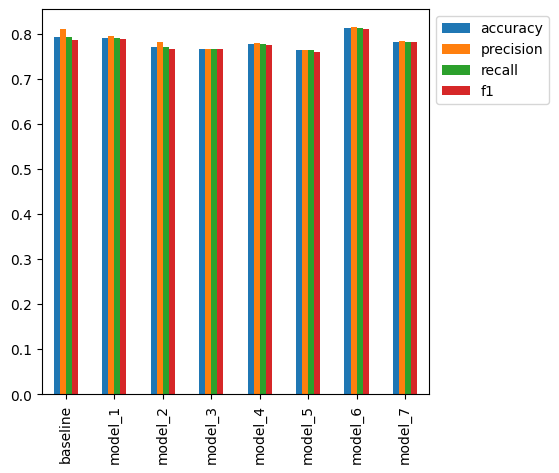

In [127]:
#plot + compare
all_model_results.plot(kind="bar", figsize=(5,5)).legend(bbox_to_anchor=(1.0,1.0));

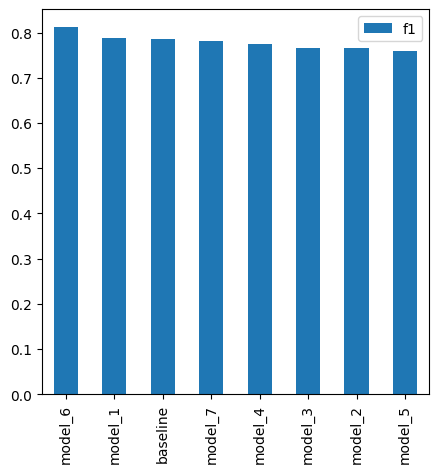

In [132]:
#Sort model results by f1-score
all_model_results.sort_values("f1", ascending= False)["f1"].plot(kind="bar", figsize =(5,5)).legend(bbox_to_anchor=(1.0,1.0));

In [133]:
#Saving and loading a trained model: HDF5 format, SaveModel format

model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [134]:
#Load model wiht custom hub layer (required for h5 models)

loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects ={"KerasLayer": hub.KerasLayer}) #need to do this because of our custom layer


In [135]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 22ms/step - loss: 0.4296 - accuracy: 0.8123


[0.4295618236064911, 0.8123359680175781]

In [136]:
#saved with SavedModel

model_6.save("model_6_SavedModel_format")

In [137]:
loaded_model_6_savedmodel = tf.keras.models.load_model("model_6_SavedModel_format")

In [139]:
loaded_model_6_savedmodel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 32ms/step - loss: 0.4296 - accuracy: 0.8123


[0.4295618236064911, 0.8123359680175781]

In [144]:
#Finding the most wrong examples

#model driven data evaluation

#Create DataFrame with validation sentences and val labels

val_df = pd.DataFrame({"text":val_sentences,
                       "target":val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})

val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.186300
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.786900
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.985122
3,@camilacabello97 Internally and externally scr...,1,0.0,0.201693
4,Radiation emergency #preparedness starts with ...,1,1.0,0.752245


In [149]:
#find the wrong predictions, sort by pred probs
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] #false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.914728
759,FedEx will no longer transport bioterror patho...,0,1.0,0.896465
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.849054
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.826131
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.823709
628,@noah_anyname That's where the concentration c...,0,1.0,0.820110
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.812781
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.807194
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.789073
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.786900


In [155]:
most_wrong[-10:] #false negatives

,text,target,pred,pred_prob
221,going to redo my nails and watch behind the sc...,1,0.0,0.065999
681,'The way you move is like a full on rainstorm ...,1,0.0,0.064342
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.055172
233,I get to smoke my shit in peace,1,0.0,0.053517
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.051464
59,You can never escape me. Bullets don't harm me...,1,0.0,0.049252
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.044022
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.034631
38,Why are you deluged with low self-image? Take ...,1,0.0,0.031473
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.024330


In [152]:
#CHECK FOR FALSE POSITIVES
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, pred: {pred}, pred_prob: {pred_prob}")
  print(f"Text:\n {text}\n")
  print("----\n")

Target: 0, pred: 1.0, pred_prob: 0.9147282838821411
Text:
 ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, pred: 1.0, pred_prob: 0.8964653611183167
Text:
 FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, pred: 1.0, pred_prob: 0.8490539193153381
Text:
 @madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, pred: 1.0, pred_prob: 0.8261308073997498
Text:
 @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, pred: 1.0, pred_prob: 0.8237090110778809
Text:
 åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Tent Collapse Story: Correction: Tent Collapse story åÈ http://t.co/fDJUYvZMrv @wizkidayo

----

Target: 0, pred: 1.0, pred_prob: 0.820110023021698
Text:
 @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUC

In [156]:
#CHECK FOR FALSE NEGATIVES
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, pred: {pred}, pred_prob: {pred_prob}")
  print(f"Text:\n {text}\n")
  print("----\n")

Target: 1, pred: 0.0, pred_prob: 0.06599850952625275
Text:
 going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, pred: 0.0, pred_prob: 0.0643421933054924
Text:
 'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, pred: 0.0, pred_prob: 0.05517182871699333
Text:
 Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, pred: 0.0, pred_prob: 0.05351678654551506
Text:
 I get to smoke my shit in peace

----

Target: 1, pred: 0.0, pred_prob: 0.051464442163705826
Text:
 @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, pred: 0.0, pred_prob: 0.04925181344151497
Text:
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, pred: 0.0, pr

In [157]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [159]:
#Making predictions on test dataset
test_sentences = test_df["text"].to_list()
test_sentences[:10]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan',
 "We're shaking...It's an earthquake",
 "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
 'Hey! How are you?',
 'What a nice hat?',
 'Fuck off!']

In [161]:
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob:.2f}")
  print(f"Text: \n{test_sample}\n")
  print("---\n")

1/1 [==============================] - 0s 105ms/step
Pred: 1, Prob: 0.81
Text: 
WAS Times: PawSox owners public return from whirlwind trip to Durham http://t.co/07nKMO7VaS

---

1/1 [==============================] - 0s 160ms/step
Pred: 0, Prob: 0.24
Text: 
'Behold your house is being left to you desolate!' (Matthew 23:38 NASB)

---

1/1 [==============================] - 0s 96ms/step
Pred: 0, Prob: 0.09
Text: 
New Explosion-proof Tempered Glass Screen Protector Film for Blackberry Z10 - Full read byÛ_ http://t.co/u1RKPJ3Cbc http://t.co/sJtxhtx71q

---

1/1 [==============================] - 0s 133ms/step
Pred: 0, Prob: 0.04
Text: 
Mega keen for hiking tomorrow! Hope i don't fall off a cliff haha!  #keen #fitness #yay #excitedmuch

---

1/1 [==============================] - 0s 79ms/step
Pred: 1, Prob: 0.64
Text: 
Link lets you pick a city bomb size and altitude of detonation. Ace! https://t.co/wmW1wqvbR8

---

1/1 [==============================] - 0s 94ms/step
Pred: 1, Prob: 0.89
Te

In [162]:
#speed/score tradeoff
import time
def pred_timer(model, samples):
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time

  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [166]:
#calculate TF baseline_results
model_6_total_pred, model_6_time_per_pred = pred_timer(model = model_6,
                                                       samples = (val_sentences))
model_6_total_pred, model_6_time_per_pred

24/24 [==============================] - 0s 10ms/step


(0.3706733870003518, 0.0004864480144361572)

In [167]:
baseline_total_pred, baseline_time_per_pred = pred_timer(model = model_0,
                                                       samples = (val_sentences))
baseline_total_pred, baseline_time_per_pred

(0.030030304999854707, 3.940984908117415e-05)

In [ ]:
#baseline is 10x faster

Text(0, 0.5, 'f1 score')

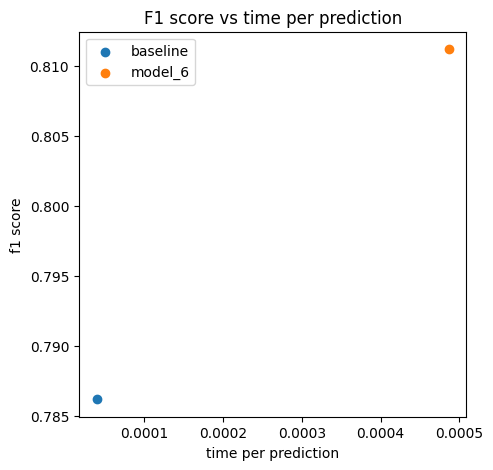

In [169]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="model_6")
plt.legend(
)
plt.title("F1 score vs time per prediction")
plt.xlabel("time per prediction")
plt.ylabel("f1 score")